<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/House_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download files



- **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **3SsnPorch**: Three season porch area in square feet
- **Alley**: Type of alley access
- **Bedroom**: Number of bedrooms above basement level
- **BldgType**: Type of dwelling
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **BsmtQual**: Height of the basement
- **BsmtUnfSF**: Unfinished square feet of basement area
- **CentralAir**: Central air conditioning
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **Electrical**: Electrical system
- **EnclosedPorch**: Enclosed porch area in square feet
- **ExterCond**: Present condition of the material on the exterior
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **ExterQual**: Exterior material quality
- **Fence**: Fence quality
- **FireplaceQu**: Fireplace quality
- **Fireplaces**: Number of fireplaces
- **Foundation**: Type of foundation
- **FullBath**: Full bathrooms above grade
- **Functional**: Home functionality rating
- **GarageArea**: Size of garage in square feet
- **GarageCars**: Size of garage in car capacity
- **GarageCond**: Garage condition
- **GarageFinish**: Interior finish of the garage
- **GarageQual**: Garage quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GrLivArea**: Above grade (ground) living area square feet
- **HalfBath**: Half baths above grade
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **HouseStyle**: Style of dwelling
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **LandContour**: Flatness of the property
- **LandSlope**: Slope of property
- **LotArea**: Lot size in square feet
- **LotConfig**: Lot configuration
- **LotFrontage**: Linear feet of street connected to property
- **LotShape**: General shape of property
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **MasVnrArea**: Masonry veneer area in square feet
- **MasVnrType**: Masonry veneer type
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **Neighborhood**: Physical locations within Ames city limits
- **OpenPorchSF**: Open porch area in square feet
- **OverallCond**: Overall condition rating
- **OverallQual**: Overall material and finish quality
- **PavedDrive**: Paved driveway
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **RoofMatl**: Roof material
- **RoofStyle**: Type of roof
- **SaleCondition**: Condition of sale
- **SaleType**: Type of sale
- **ScreenPorch**: Screen porch area in square feet
- **Street**: Type of road access
- **TotalBsmtSF**: Total square feet of basement area
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Utilities**: Type of utilities available
- **WoodDeckSF**: Wood deck area in square feet
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **YrSold**: Year Sold

# Configure and import

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [124]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Data Import

In [75]:
original_train_df = pd.read_csv('train.csv')
original_train_df['Source'] = 'train.csv'

original_test_df = pd.read_csv('test.csv')
original_test_df['Source'] = 'test.csv'

total_df = pd.concat([original_train_df, original_test_df], axis=0)

# Data Exploration

In [118]:
list_of_numerics = total_df.select_dtypes(include=['float', 'int']).columns
corrSalePrice = round(total_df[numerical_columns].corrwith(original_train_df['SalePrice']), 3) * 100
types = total_df.dtypes
missing = round((total_df.isnull().sum()/total_df.shape[0]),3)*100
overview = total_df.apply(
    lambda x: [
      round(x.min()), 
      round(x.max()), 
      round(x.mean()), 
      round(x.quantile(0.5))
    ] if x.name in list_of_numerics else x.unique())
outliers = total_df.apply(
    lambda x: sum(
        (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)))) | 
        (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)))) 
      if x.name in list_of_numerics else ''))
explore_df = pd.DataFrame({
  'Types': types,
  'CorrSalePrice%': corrSalePrice,
  'Missing%': missing,
  'Overview': overview,
  'Outliers': outliers
})
explore_df['Types'] = explore_df['Types'].astype(str)
explore_df.sort_values(by=['Missing%'], ascending=False).transpose()

,SalePrice,1stFlrSF,LowQualFinSF,MoSold,MiscVal,MiscFeature,MasVnrType,MasVnrArea,MSZoning,MSSubClass,LotShape,OpenPorchSF,LotFrontage,LotConfig,LotArea,LandSlope,LandContour,KitchenQual,KitchenAbvGr,Id,Neighborhood,OverallCond,2ndFlrSF,Source,YearRemodAdd,YearBuilt,WoodDeckSF,Utilities,TotalBsmtSF,TotRmsAbvGrd,Street,ScreenPorch,OverallQual,SaleType,SaleCondition,RoofStyle,RoofMatl,PoolQC,PoolArea,PavedDrive,...,Heating,HalfBath,Condition2,Condition1,CentralAir,BsmtUnfSF,BsmtQual,BsmtHalfBath,BsmtFullBath,BsmtFinType2,BsmtFinType1,BsmtFinSF2,BsmtFinSF1,BsmtExposure,BsmtCond,BldgType,BedroomAbvGr,Alley,3SsnPorch,Electrical,EnclosedPorch,ExterCond,GarageArea,GrLivArea,GarageYrBlt,GarageType,GarageQual,GarageFinish,GarageCond,GarageCars,Functional,ExterQual,FullBath,Foundation,Fireplaces,FireplaceQu,Fence,Exterior2nd,Exterior1st,YrSold
Types,float64,int64,int64,int64,int64,object,object,float64,object,int64,object,int64,float64,object,int64,object,object,object,int64,int64,object,int64,int64,object,int64,int64,int64,object,float64,int64,object,int64,int64,object,object,object,object,object,int64,object,...,object,int64,object,object,object,float64,object,float64,float64,object,object,float64,float64,object,object,object,int64,object,int64,object,int64,object,float64,int64,float64,object,object,object,object,float64,object,object,int64,object,int64,object,object,object,object,int64
CorrSalePrice%,NaN,30.3,-2.4,3.7,-1.1,NaN,NaN,22.9,NaN,-3.1,NaN,16,-0,NaN,17.9,NaN,NaN,NaN,-6.2,-1.1,NaN,-3.7,16.4,NaN,26.2,27.6,17.2,NaN,32.2,28.5,NaN,7.1,38.7,NaN,NaN,NaN,NaN,NaN,5.4,NaN,...,NaN,15.1,NaN,NaN,NaN,12.8,NaN,0.5,12.2,NaN,NaN,-1.8,19.5,NaN,NaN,NaN,9.7,NaN,2.1,NaN,-7.5,NaN,32,37.2,13.5,NaN,NaN,NaN,NaN,32.2,NaN,NaN,29,NaN,25.6,NaN,NaN,NaN,NaN,-1
Missing%,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Overview,"[34900, 755000, 180921, 163000.0]","[334, 5095, 1160, 1082.0]","[0, 1064, 5, 0.0]","[1, 12, 6, 6.0]","[0, 17000, 51, 0.0]","[None, Shed, Gar2, Othr, TenC]","[BrkFace, None, Stone, BrkCmn]","[0, 1600, 101, 0.0]","[RL, RM, C (all), FV, RH]","[20, 190, 57, 50.0]","[Reg, IR1, IR2, IR3]","[0, 742, 47, 26.0]","[69, 69, 69, 69.0]","[Inside, FR2, Corner, CulDSac, FR3]","[1300, 215245, 10168, 9453.0]","[Gtl, Mod, Sev]","[Lvl, Bnk, Low, HLS]","[Gd, TA, Ex, Fa]","[0, 3, 1, 1.0]","[1, 2919, 1460, 1460.0]","[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...","[1, 9, 6, 5.0]","[0, 2065, 336, 0.0]","[train.csv, test.csv]","[1950, 2010, 1984, 1993.0]","[1872, 2010, 1971, 1973.0]","[0, 1424, 94, 0.0]","[AllPub, NoSeWa]","[0, 6110, 1051, 989.0]","[2, 15, 6, 6.0]","[Pave, Grvl]","[0, 576, 16, 0.0]","[1, 10, 6, 6.0]","[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...","[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...","[Gable, Hip, Gambrel, Mansard, Flat, Shed]","[CompShg, WdShngl, Metal, WdShake, Membran, Ta...","[None, Ex, Fa, Gd]","[0, 800, 2, 0.0]","[Y, N, P]",...,"[GasA, GasW, Grav, Wall, OthW, Floor]","[0, 2, 0, 0.0]","[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...","[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...","[Y, N]","[0, 2336, 561, 467.0]","[Gd, TA, Ex, None, Fa]","[0, 2, 0, 0.0]","[0, 3, 0, 0.0]","[Unf, BLQ, None, ALQ, Rec, LwQ, GLQ]","[GLQ, ALQ, Unf, Rec, BLQ, None, LwQ]","[0, 1526, 50, 0.0]","[0, 5644, 441, 368.0]","[No, Gd, Mn, Av, None]","[TA, Gd, None, Fa, Po]","[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]","[0, 8, 3, 3.0]","[None, Grvl, Pave]","[0, 508, 3, 0.0]","[SBrkr, FuseF, FuseA, FuseP, Mix]","[0, 1012, 23, 0.0]","[TA, Gd, Fa, Po, Ex]","[0, 1488, 473, 480.0]","[334, 5642, 1501, 1444.0]","[0, 2207, 1870, 1977.0]","[Attchd, Detchd, BuiltIn, CarPort, None, Basme...","[TA, Fa, Gd, None, Ex, Po]","[RFn, Unf, Fin, None]","[TA, Fa, None, Gd, Po, Ex]","[0, 5, 2, 2.0]","[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]","[Gd, TA, Ex, Fa]","[0, 4, 2, 2.0]","[PConc, CBlock, BrkTil, Wood, Slab, Stone]","[0, 4, 1, 1.0]","[None, TA, Gd, F

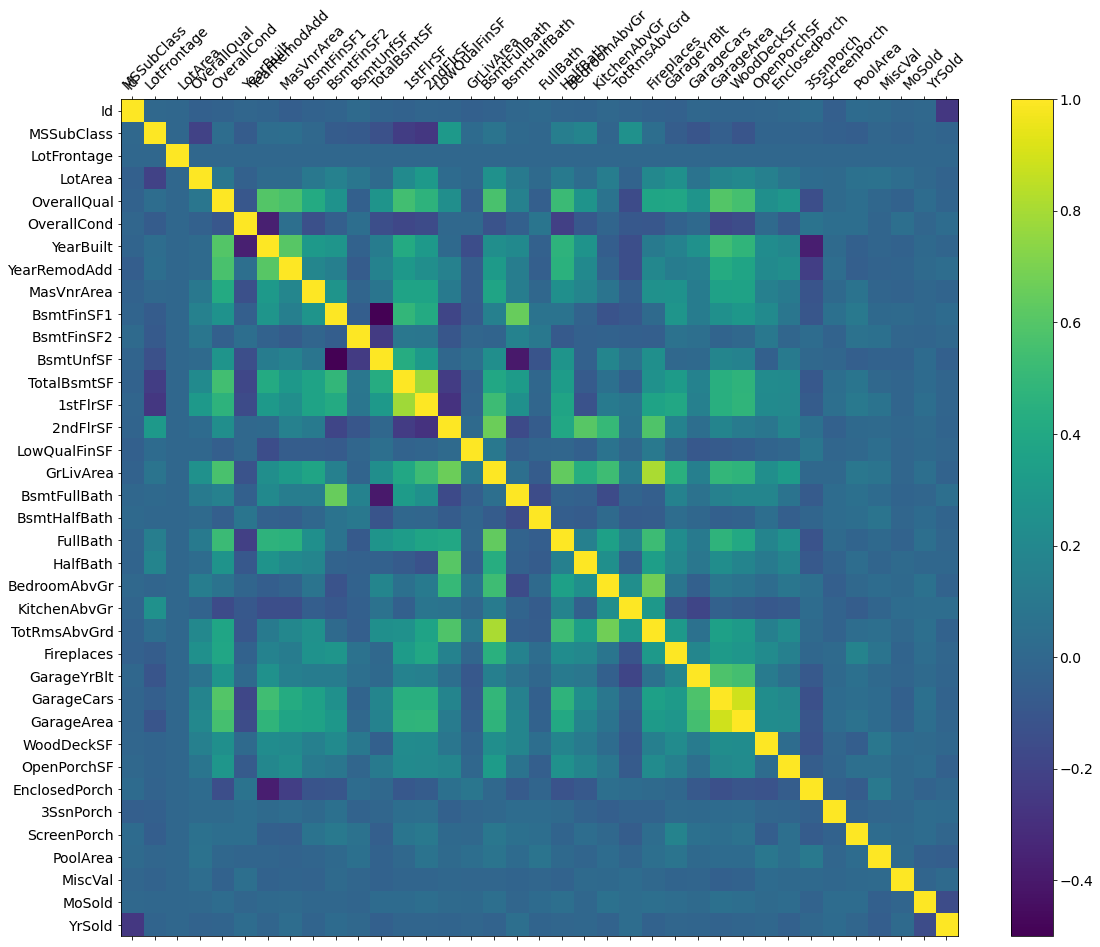

In [130]:
# Plot Correlation Matrix

temp_df = total_df[numerical_columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(temp_df.corr(), fignum=f.number)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Preprocessing

In [117]:
# Manage missing values
# Based on the number of missing values, 
# decide if makes sense or not to create a dedicated category called "None",
# or if it is simply better to assign a mean() value

for column in ['Alley', 'MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']:
  total_df[column] = total_df[column].fillna('None')
for column in ['Electrical','MSZoning','Exterior1st','Exterior2nd','KitchenQual','SaleType','Functional', 'Utilities']:
  total_df[column] = total_df[column].fillna(total_df[column].mode()[0])
for column in ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath', 'GarageYrBlt','GarageCars','GarageArea']:
  total_df[column] = total_df[column].fillna(0)
for column in ['LotFrontage']:
  total_df[column] = total_df[column].mean()

In [128]:
# Remove outsiders

total_df = total_df[total_df['GrLivArea'] < 4000]

## Data Exploration

In [131]:
numerical_columns = []
categorical_columns = []

for column in total_df.columns:
  if total_df.dtypes[column] == np.int64 or total_df.dtypes[column] == np.float64:
    numerical_columns.append(column)
  else:
    categorical_columns.append(column)

categorical_columns.remove('Source')
numerical_columns.remove('SalePrice')

In [ ]:
# GarageYrBlt
# MiscVal
# Id
# YrSold 
# BsmtHalfBath
# numerical_columns.remove('GarageYrBlt')
# numerical_columns.remove('MiscVal')
# numerical_columns.remove('Id')
# numerical_columns.remove('YrSold')
# numerical_columns.remove('BsmtHalfBath')

In [ ]:
cp_total_df = total_df
# cp_total_df = cp_total_df.drop(['Id'], axis=1)
# cp_total_df = cp_total_df.drop(['GarageYrBlt', 'MiscVal', 'Id', 'YrSold', 'BsmtHalfBath'], axis=1)

In [132]:
pd.options.mode.chained_assignment = None

for column in categorical_columns:
  cp_total_df[column] = LabelEncoder().fit_transform(cp_total_df[column])

for column in categorical_columns:
  cp_total_df[column] = cp_total_df[column].astype('category')

In [133]:
train_df = cp_total_df[cp_total_df['Source'] == 'train.csv']
train_output_df = pd.DataFrame(train_df['SalePrice'], columns=['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)

test_df = cp_total_df[cp_total_df['Source'] == 'test.csv']
test_df.drop('SalePrice', axis=1, inplace=True)

In [134]:
def create_tensor(input_df):
  stack = []
  for column in categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  for column in numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

tensor_train = create_tensor(train_df).float()
tensor_output = torch.tensor(train_output_df['SalePrice']).flatten().float()

tensor_test = create_tensor(test_df).float()

In [143]:
total_records_train = len(tensor_train)
test_records_train = int(total_records_train * 0.2)

tensor_train_data = tensor_train[:total_records_train-test_records_train]
tensor_train_output = tensor_output[:total_records_train-test_records_train]

tensor_validation_data = tensor_train[total_records_train-test_records_train:total_records_train]
tensor_validation_output = tensor_output[total_records_train-test_records_train:total_records_train]

In [182]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(tensor_train.shape[1], 1000)
    self.linear2 = nn.Linear(1000, 500)
    self.linear3 = nn.Linear(500, 200)
    self.linear4 = nn.Linear(200, 1)
  def forward(self, x):
    y = self.linear1(x)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear2(y)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear3(y)
    y = torch.nn.functional.dropout(y, p=0.2)
    y = self.linear4(y)
    return y

In [145]:
model = Model()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [183]:
def train_model(epochs, x, y):
  aggregated_losses = []
  for i in range(epochs):
    y_pred = model(x)
    loss = loss_function(y_pred.squeeze(), y)
    optimizer.zero_grad() # sets the gradients of all optimized to zero.
    loss.backward() # compute gradient of loss with respect to all the parameters
    optimizer.step() # iterate and update all parameters based on the current gradient
    if i % 100 == 0:
      print("epoch: " + str(i) + "\tloss: " + str(loss.item()))
    if i % 50 == 0:
      aggregated_losses.append(loss)
  return aggregated_losses

In [184]:
def plot_losses(aggregated_losses):
  plt.plot(range(0, len(aggregated_losses)), aggregated_losses)
  plt.ylabel('Loss')
  plt.xlabel('epoch');

In [190]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
epochs = 600

for fold, (train_index, test_index) in enumerate(kf.split(tensor_train_data, tensor_train_output)):
  print("FOLD", fold)
  x_train_fold = tensor_train_data[train_index] 
  y_train_fold = tensor_train_output[train_index]
  aggregated_losses = train_model(epochs, x_train_fold, y_train_fold)

FOLD 0
epoch: 0	loss: 1035765824.0
epoch: 100	loss: 924374464.0
epoch: 200	loss: 978115200.0
epoch: 300	loss: 991743936.0
epoch: 400	loss: 996373568.0
epoch: 500	loss: 1046372480.0
FOLD 1
epoch: 0	loss: 955509952.0
epoch: 100	loss: 923802944.0
epoch: 200	loss: 922286208.0
epoch: 300	loss: 951096896.0
epoch: 400	loss: 948636800.0
epoch: 500	loss: 955579008.0
FOLD 2
epoch: 0	loss: 1035386240.0
epoch: 100	loss: 948474112.0
epoch: 200	loss: 898806720.0
epoch: 300	loss: 894973568.0
epoch: 400	loss: 932018304.0
epoch: 500	loss: 908467136.0
FOLD 3
epoch: 0	loss: 982336384.0
epoch: 100	loss: 941456000.0
epoch: 200	loss: 939716416.0
epoch: 300	loss: 996208832.0
epoch: 400	loss: 928976704.0
epoch: 500	loss: 948253696.0
FOLD 4
epoch: 0	loss: 793271168.0
epoch: 100	loss: 788417088.0
epoch: 200	loss: 755357376.0
epoch: 300	loss: 707143488.0
epoch: 400	loss: 784356160.0
epoch: 500	loss: 752003840.0
FOLD 5
epoch: 0	loss: 946285632.0
epoch: 100	loss: 876291328.0
epoch: 200	loss: 823776512.0
epoch: 300

In [ ]:
aggregated_losses = train_model(1000)
plot_losses(aggregated_losses)
# 900 --> 1098404864.0

In [192]:
# Overfitting if: training loss << validation loss
# Underfitting if: training loss >> validation loss
# Just right if training loss ~ validation loss

with torch.no_grad():
    y_val = model(tensor_validation_data)
    loss = loss_function(y_val.squeeze(), tensor_validation_output)
print("Loss: " + str(loss.item()))
# Loss -- >Loss: 2240462848.0

Loss: 2530632704.0


In [ ]:
# To remove overfitting
# cross-validation: use your initial training data to generate multiple mini train-test splits.
# Remove features: removing irrelevant input features or aggregate them 
# Early stopping: stopping the training process before the learner degradates.
regularization,
# Ensembling: machine learning methods for combining predictions from multiple separate models. 

In [193]:
# Make predictions
with torch.no_grad():
    y_pred = model(tensor_test)
print("Loss: " + str(loss))

Loss: tensor(2.5306e+09)


In [194]:
submission_df = pd.DataFrame(y_pred, columns=['SalePrice']).astype("float")

submission_df = pd.concat([original_test_df, submission_df], axis=1)

submission_df = submission_df[['Id', 'SalePrice']]

from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>